In [2]:
import os
import numpy as np

from eswl.tools import deserialize
from eswl.tools import plotTF
from eswl.tools import plot_diagrams

from scipy.sparse.linalg import eigs
from scipy.linalg import svd

import matplotlib.pyplot as plt
import json

cmp = plt.rcParams['axes.prop_cycle'].by_key()['color']

# File paths for saving/loading data and results
data_path = os.path.join(os.getcwd(), 'data')
simres_file = os.path.join(data_path, 'SimResults.json')

In [3]:
# Load simulation results
if not os.path.exists(simres_file):
    raise FileNotFoundError(
        f"{simres_file} not found. Generate simulation results using script main0.py."
    )
else:
    with open(simres_file, 'r') as json_file:
        data = deserialize ( json.load(json_file) )
        results = data['results']
        ESWLresults = data['ESWLresults']
        modalInfo = data['modalInfo']
        nodalInfo = data['nodalInfo']
        time = data['time']
        drag_forces = data['drag_forces']
        structuralModel = data['structuralModel']
        windModel = data['windModel']
        aeroSec = data['aeroSec']        

# Access structural model details
XNOD = structuralModel['XNOD']
iDOF_obs = structuralModel['iDOF_obs']-1  # Convert to 1D array
iDOF_obs = np.array(iDOF_obs).flatten()
iDOF_obs = iDOF_obs[[1, 3, 5]]

# Define index arrays
i_x = np.arange(0, 170, 2) # keep only x-displacements
i_m = np.arange(170, 255)

Processing combination 1/14
Processing combination 2/14
Processing combination 3/14
Processing combination 4/14
Processing combination 5/14
Processing combination 6/14
Processing combination 7/14
Processing combination 8/14
Processing combination 9/14
Processing combination 10/14
Processing combination 11/14
Processing combination 12/14
Processing combination 13/14
Processing combination 14/14


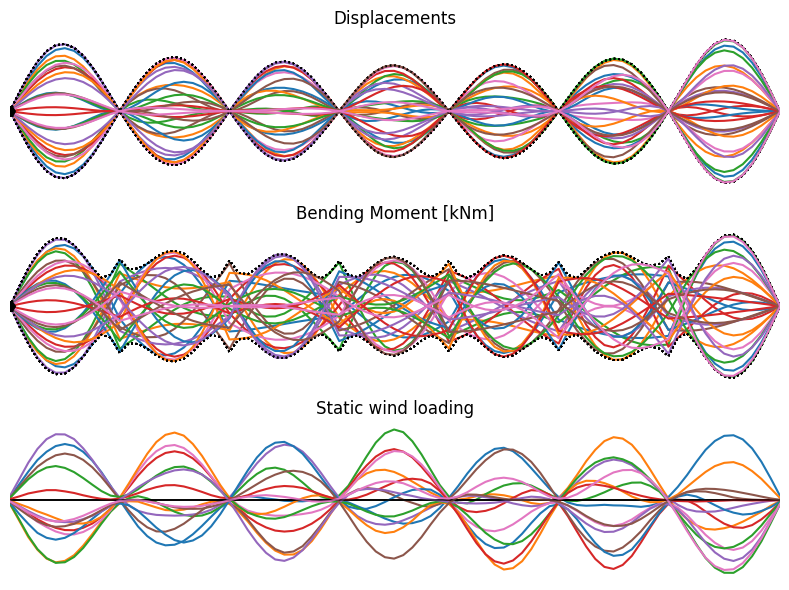

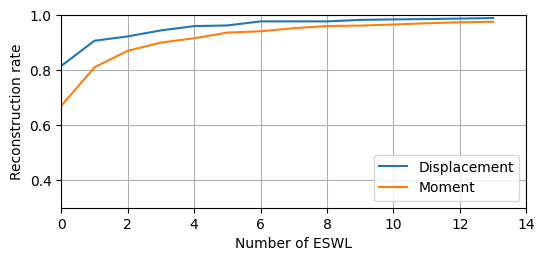

In [11]:
from eswl import tools as tools

import importlib
importlib.reload(tools)

# Configuration
nb_comb = 14  # Number of combinations
n_trials = 5000 # Number of trials per combination

# Targets
target_x = np.abs(ESWLresults['z_max'][i_x])
target_m = np.abs(ESWLresults['z_max'][i_m])
metric_x = np.sum(target_x)
metric_m = np.sum(target_m)

# Storage
x_rec = np.zeros((len(i_x), nb_comb))
m_rec = np.zeros((len(i_m), nb_comb))
reconst_rate = np.zeros((nb_comb, 2))
trial_coefs = np.zeros((7, n_trials, nb_comb))
coefs = np.zeros((7, nb_comb))

# Color map
cmp = plt.rcParams['axes.prop_cycle'].by_key()['color']


# Create PSWL
eswl = ESWLresults['ESWL'][:, :, 1]  # MATLAB index 2 -> Python index 1
eswl[:, -1] = 2 * eswl[:, -2] - eswl[:, -3]
U, S, Vh = svd(eswl, full_matrices=False)

i_z = 0
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

for i_comb in range(nb_comb):
    print(f'Processing combination {i_comb + 1}/{nb_comb}')

    iclr = i_comb % 7
    clr = cmp[iclr]

    # Trials for this combination
    reconst_rate_trial = np.zeros((n_trials, 2))
    
    x_rec_trial = x_rec.copy()
    m_rec_trial = m_rec.copy()
    
    for i_trial in range(n_trials):
        
        trial_coefs[:, i_trial, i_comb] = np.random.randn(7)
        trial_eswl = U[:, :7] @ trial_coefs[:, i_trial, i_comb]

        x_t, m_t, _ = tools.plot_diagrams(ESWLresults, structuralModel, i_x, i_m, [i_z], clr, trial_eswl, fit_env_scale=True, doplot=False, ax=ax)
        x_t = x_t.flatten()
        m_t = m_t.flatten()

        x_rec_trial[:, i_comb] = x_t
        m_rec_trial[:, i_comb] = m_t

        x_env_t = np.max(np.column_stack([x_rec_trial, -x_rec_trial]), axis=1)
        m_env_t = np.max(np.column_stack([m_rec_trial, -m_rec_trial]), axis=1)

        x_env_tmp = x_env_t.copy()
        m_env_tmp = m_env_t.copy()

        x_env_tmp[x_env_t > target_x] = target_x[x_env_t > target_x]
        m_env_tmp[m_env_t > target_m] = target_m[m_env_t > target_m]

        reconst_rate_trial[i_trial, 0] = np.sum(x_env_tmp) / metric_x
        reconst_rate_trial[i_trial, 1] = np.sum(m_env_tmp) / metric_m

    # Keep best trial
    i_best = np.argmax(np.mean(reconst_rate_trial, axis=1))
    coefs[:, i_comb] = trial_coefs[:, i_best, i_comb]
    reconst_rate[i_comb, :] = reconst_rate_trial[i_best, :]

    # Final ESWL for best trial    
    eswl = U[:, :7] @ coefs[:, i_comb]
    x_final, m_final, _ = tools.plot_diagrams(ESWLresults, structuralModel, i_x, i_m, [i_z], clr, eswl, fit_env_scale=True, ax=ax)

    x_rec[:, i_comb] = x_final.flatten()
    m_rec[:, i_comb] = m_final.flatten()

    x_env = np.max(np.column_stack([x_rec[:, i_comb], -x_rec[:, i_comb]]), axis=1)
    m_env = np.max(np.column_stack([m_rec[:, i_comb], -m_rec[:, i_comb]]), axis=1)

# Convergence plot
plt.figure(999)
plt.plot(reconst_rate)
plt.grid(True)
plt.ylim([0.3, 1])
plt.xlim([0, 14])
plt.gcf().set_size_inches(6, 2.5)
plt.xlabel('Number of ESWL')
plt.ylabel('Reconstruction rate')
plt.legend(['Displacement', 'Moment'], loc='lower right')
plt.show()

